# 파이썬 언어의 특징

직관적인 문법을 가진 언어(초보자 진입 쉬움)

객체지향언어(함수, 클래스 등을 활용해 다양한 작업을 편리하게 할 수 있음)

인터프리터 언어(바로 확인할 수 있어서 데이터분석에 편리)

여러 언어와 함께 쓸 수 있는 언어(R, C등과 함께 쓸 수 있음)

OS에 종속되지 않는 언어(window/linux/mac)

In [1]:
# 시간 측정을 위한 세팅
from timeit import default_timer
start = default_timer()

# 계산 및 시각화를 위한 세팅
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
# 시작시간 세팅
st = default_timer()

# 데이터 불러오기
movies = pd.read_csv('./data/movie.csv')
ratings = pd.read_csv('./data/rating.csv')
    
# movie ID 기준으로 순서를 맞추고, 인덱스 다시 부여
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

# ratings의 형식 출력
print(ratings.dtypes)

# movie의 연도를 데이트타임 형식으로 바꿔주기 + 제목은 인덱스 기준 -7까지만 표시
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals) ## nan값 있어서 float형태로 나올 것
movies.title = movies.title.str[:-7]

# 장르를 원핫인코딩 하고 각각의 영화 별 장르를 표시해주기. 
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

# 레이팅을 데이트타임 형식으로 바꿔주고 year만 남기기
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

# movie와 rating의 nan값 체크 후기 포함된 셀 버리기
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    
# 다시 movieID로 순서대로 정렬 해주고, 인덱스 세팅
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)

#걸린 시간 계산 후 소숫점 2자리까지 반올림
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

userId         int64
movieId        int64
rating       float64
timestamp     object
dtype: object
Number of movies Null values:  22
Number of ratings Null values:  0
Elapsed time(sec):  59.17


In [ ]:
st = default_timer()

# movie의 id와 year열만 가지고 와서 year로 합쳐주기(같은 year을 인덱스로 movie가 모이도록)
dftmp = movies[['movieId', 'year']].groupby('year')

#연도별 영화의 갯수를 세서 green으로, 점으로 찍는 그래프
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)
#연도별 점수를 red로, 점으로 찍는 그래프
dftmp = ratings[['rating', 'timestamp']].groupby('timestamp')
ax2 = ax1.twinx()
ax2.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

#라벨 붙이기
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released'); ax2.set_ylabel('Number of ratings')
plt.title('Movies per year')
plt.show()

#변수정리, 시간계산
%reset_selective -f (^dftmp$|^ax1$|^ax2$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

In [ ]:
st = default_timer()

#출력 그래프 사이즈를 10,5로 맞추고 movies에서 id와 년도만 가져와서 year로 묶어주기. 
plt.figure(figsize=(10,5))
dftmp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dftmp.movieId.nunique().cumsum()})#묶어준 데이터프레임에서 id의 유니크한 갯수(중복제거 종류 수)를 누적합으로 계산해서 'all_movies'라는 항목으로 추가
# genres_unique의 genre들을 순서대로 for문을 돌리는데, movies에서 같은 genre의 id와 year을 가져오고 year로 묶어주기
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()#그것의 갯수를 누적ㅎ바으로 세서 df에 genre항목으로 저장해주기
df.fillna(method='ffill', inplace=True)#앞의 값으로 nan값을 채워주기
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))#all_movies가 아닌 항목들은 stack그래프로 그려주기
#all_movies는 o마크와 검정색으로 선그래프 그리며, 라벨 써주기
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre') 
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
#가장 아래의 행을 bar그리기
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') #첫번째 항목은 blue로 만들기
plt.xticks(rotation='vertical')#수직으로 항목이름 쓰기
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()
#변수정리, 시간계산
%reset_selective -f (^barlist$|^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

In [ ]:
st = default_timer()
#rating에서 id, rating가져와서 id로 묶고 rating의 평균 내기
dftmp = ratings[['movieId','rating']].groupby('movieId').mean()

rating_stats = []
#경계선을 blue로 하고 25개로 나뉜 히스토그램 그리기
dftmp.hist(bins=25, grid=False, edgecolor='b', density=True, label ='All genres', figsize=(10,5))#normed가 density로 바뀜. https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html
#genres_unique의 genre들을 순서대로 for문을 돌리는데, movies의 genre가 일치하는 애들을 dftmp에 담고, 
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]==True]
    dftmp = ratings[ratings.set_index('movieId').index.isin(dftmp.set_index('movieId').index)]#rating의 movieid를 인덱스로 만든다음에 dftmp의 movieid를 인덱스로 삼은것의 인덱스를가지고와서 겹치는 애들만 dftmp로 다시 담기-> dftmp의 id를 인덱스로 잡은것을 rating에서 찾아서 가져오기
    dftmp = dftmp[['movieId','rating']].groupby('movieId').mean() #id로 묶고 rating의 평균 구하기
    dftmp.rating.plot(grid=False, alpha=0.6, kind='kde', label=genre)#Kernel Density Estimate plot으로 그리기(가우시안 커널사용)
    avg = dftmp.rating.mean()#rating의 평균
    std = dftmp.rating.std()#rating의 표준편차
    rating_stats.append((genre, avg, std))#장르와 평균, 표준편차를 list에 튜플형식으로 담기
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()
#변수정리, 시간계산
%reset_selective -f (^avg$|^dftmp$|^genre$|^std$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

In [ ]:
st = default_timer()

# rating_stats에서 for 문으로 만들어 둔 genre, 평균, 표준편차를 데이터프레임으로 만들고 장르를 인덱스로 만들기
rating_sum = pd.DataFrame(rating_stats,  columns=['genre', 'average', 'std_dev'])
rating_sum.set_index('genre', inplace=True)
# rating_sum을 transpose 해주고(가로세로) 평균과 표준편차를 boxplot으로 그리기
bxplot = plt.boxplot(rating_sum.T, labels=['Average', 'STD'], sym="ro")

# boxplot에 담겨있는 fliers들을 인덱스와 값을 for문으로 출력하고, value에서 get_ydata를 사용해 y값을 추출하고, 
# rating_sum에서 i번째에 있는 값이 y값과 같은지 확인하고, 0번째 값을 가져와서 outliers에 담고
# 주석을 달아주기(xy좌표 겹치지 않게 지정)
outliers = []
for i, value in enumerate(bxplot['fliers']):
    for val in value.get_ydata():
        bxplot_label = rating_sum.index[rating_sum.iloc[:, i] == val][0]
        outliers.append(bxplot_label)
        plt.annotate(bxplot_label, xy=(i+1.1, val+np.random.uniform(-0.25,0.25))) # Trick to prevent overlapping
# 리스트를 집합으로 바꾸고 y축 한계 지정후 출력
outliers = set(outliers)
plt.ylim(0,)
plt.ylabel('Movie rating')
plt.title('Movie rating descriptive stats')
plt.show()

# rating을 hist처럼 각값/전체로 나누고 표준편차의평균을 구해줌
rating_sum['num_ratings_norm']=df.iloc[-1, 1:]/df.iloc[-1, 1:].sum()
rating_sum['average_all']=rating_sum.average.mean()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)#1x1 그리드, 첫번째 서브플롯
ax2 = ax.twinx()#x를 공유하는 쌍둥이 라인
#rating_sum에서 평균과 표준편차를 가져오고, b,r색으로 gird없게 그리기, average_all은 검정으로, num_rating_norm은 초록으로
rating_sum[['average', 'std_dev']].plot(kind='bar', color=['b','r'], ax=ax, position=0.5, grid=False)
rating_sum['average_all'].plot(kind='line',style='--', color=['black'], ax=ax, grid=False)
rating_sum['num_ratings_norm'].plot(kind='line', color='g', ax=ax2, grid=False, linewidth=3)
#범례와 라벨 정리
ax.legend(loc=2)
ax2.legend(loc=1)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Movie rating descriptive stats')
plt.autoscale()#자동 크기조정
ax2.set_ylim(0,)
plt.show()
#이상치 출력
print("Outliers: ", outliers)
print(rating_sum.T)

# num_ratings_norm 으로 정렬하고 파이차트 그리기
rating_sum.sort_values(by='num_ratings_norm', inplace=True)
plt.pie(rating_sum['num_ratings_norm'], labels=rating_sum.T.columns, labeldistance=1.5)
plt.show()


#변수정리, 시간계산
%reset_selective -f (^avg$|ax|bxplot|^df$|^dftmp$|^i$|^rating_stats$|^rating_sum$|^val$|^value$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

In [3]:
st = default_timer()
# movies의 id랑 year만 가져오고 id를 인덱스로 잡고 rating의 id, rating을 가져온것을 id기준 rating평균내준값과 id를 기준으로 join해줌->id 기준 rating의 평균과 year가 나오게 됨
dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())

plt.figure(figsize=(10,5))
plt.plot(dftmp.year, dftmp.rating,"g.", markersize=4)#year와 rating으로 scatter plot을 그림
plt.xlabel('Year')
plt.ylabel('Movie average rating')
plt.title('All movies rating')
plt.ylim(0,)
plt.show()

#변수정리, 시간계산
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

NameError: name 'movies' is not defined

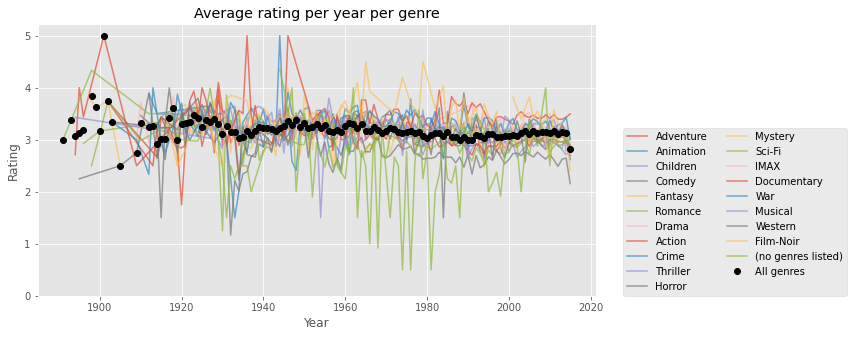

Elapsed time(sec):  28.7


In [ ]:
st = default_timer()

plt.figure(figsize=(10,5))
# 각각의 genre에 대해 for문을 돌리고,
for genre in genres_unique.genre:
    # movie중 genre 맞는 애들만 가져와서 id, year을 뽑아주고 id기준으로 인덱스를 잡는다
    dftmp = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')

    # rating의 id를 기준으로 정렬한 데이터프레임을 dftmp의 index와 일치하는 것들만 뽑은 후 거기서 id, rating 을 가져와서 id기준으로 모은 후 rating의 평균값을 구한다. 그것과 dftmp를 join시킨다.
    dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    # year기준으로 rating을 평균값을 구한다.
    dftmp = dftmp.groupby('year').mean()
    plt.plot(dftmp, label = genre, alpha=0.7) #투명도를 주고 plot을 그려준다

# movies의 id, year을 가져오고 id를 인덱스로 삼아준다
dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]#위와 같이 해준다. 차이점은 전체 genre라는 것
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "o", label='All genres', color='black')#원형, 점으로 plot을 찍어준다.

plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating per year per genre')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()

#변수정리, 시간계산
%reset_selective -f (^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

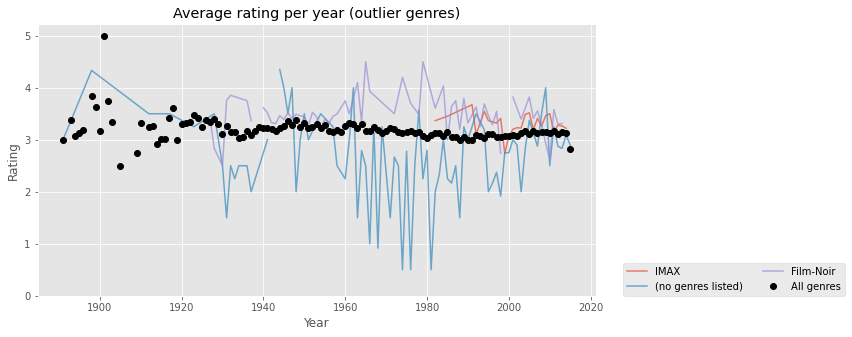

Elapsed time(sec):  5.85


In [ ]:
st = default_timer()

plt.figure(figsize=(10,5))
for genre in outliers:
    # Select only movies matching current genre. Pick only movieId (as index) and year.
    dftmp = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')
    # Selects ratings, with movieId as index. Select only movies that match also the previous step. Join both.
    dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    # Now we have a df of movieId, year and multiple ratings. Group by year and compute the average rating.
    dftmp = dftmp.groupby('year').mean()
    plt.plot(dftmp, label = genre, alpha=0.7)

# For all genres
dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "o", label='All genres', color='black')
    
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating per year (outlier genres)')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()

#변수정리, 시간계산
%reset_selective -f (^dftmp$|^genre$|^outliers$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


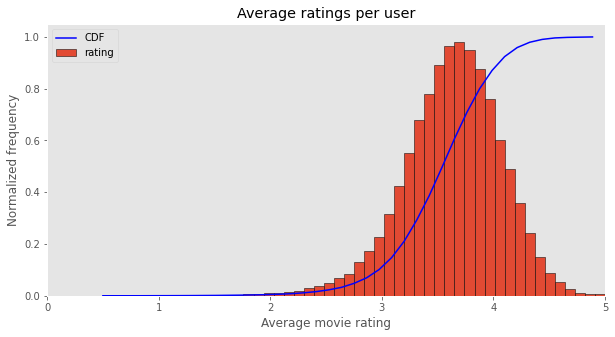

Elapsed time(sec):  1.13


In [ ]:
st = default_timer()

# rating의 id와 rating를 가져와서 id를 기준으로 rating을 평균내준다
dftmp = ratings[['userId','rating']].groupby('userId').mean()
# 50개로 나눠진 histogram을 그린다.
dftmp.plot(kind='hist', bins=50, grid=0, density=True, edgecolor='black', figsize=(10,5))
# 40으로 나눈 histogram을 그리고 value와 base를 받는다(도수, 구분구간)
values, base = np.histogram(dftmp, bins=40, normed=True)
# value의 누적합과 base의 차분의 평균을 구하고 곱한 후 cumulative에 담는다
cumulative = np.cumsum(values) * np.diff(base).mean()
# cumulative를 plot으로 그려준다.
plt.plot(base[:-1], cumulative, c='blue', label='CDF')
plt.xlim(0,5)
plt.legend()
plt.xlabel ('Average movie rating')
plt.ylabel ('Normalized frequency')
plt.title ('Average ratings per user')
plt.show()

#변수정리, 시간계산
%reset_selective -f (^dftmp$|^base$|^cumulative$|^values$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

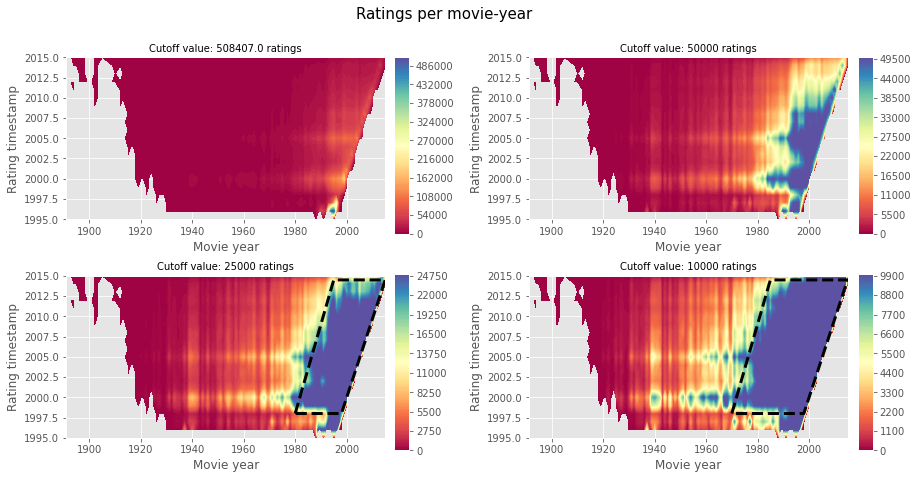

Elapsed time(sec):  3.82


In [ ]:
st = default_timer()
# Combine movies year with ratings timestamps
dftmp = movies[['movieId', 'year']].merge(ratings[['movieId', 'timestamp']], on='movieId')
dftmp = dftmp.groupby(['year', 'timestamp']).count().reset_index()
dftmp.columns=['year', 'timestamp', 'count']
dftmp = dftmp.pivot('year', 'timestamp')

# Plot using a contour (color reflects number of ratings for each year-timestamp pair).
# Could also use heatmap or imshow...
X=dftmp.columns.levels[1].values
Y=dftmp.index.values
Z=dftmp.values
Xi,Yi = np.meshgrid(X, Y)

fig, axs = plt.subplots(2,2)
fig.set_size_inches(14,7)
cutoff = [np.nanmax(Z), 50000, 25000, 10000] # Modify the contour plots a different max values.
Zcap = np.copy(Z)
locx = [0.45, 0.91, 0.45, 0.91] # x location for the individual colorbars
locy = [0.53, 0.53, 0.1, 0.1] # y location for the individual colorbar
for i, ax in enumerate(axs.flatten()):
    Zcap[Zcap>cutoff[i]]=cutoff[i]
    cmvals = ax.contourf(Yi, Xi, Zcap, 100, cmap="Spectral")
    ax.set_xlabel('Movie year')
    ax.set_ylabel('Rating timestamp')
    ax.set_title('Cutoff value: %s ratings' %cutoff[i], fontsize=10)
    cax = fig.add_axes([locx[i], locy[i], 0.015, 0.35])
    fig.colorbar(cmvals, cax=cax, orientation='vertical')
fig.suptitle('Ratings per movie-year', fontsize=15)
plt.subplots_adjust(hspace=0.35,wspace=0.45)

# Highlight key regions in the plots, just roughly...
axs.flatten()[2].plot([1980, 1995, 2015, 1998, 1980], [1998, 2014.5, 2014.5, 1998, 1998], 
                      '--', color='black',linewidth=3)
axs.flatten()[3].plot([1970, 1985, 2015, 1998, 1970], [1998, 2014.5, 2014.5, 1998, 1998], 
                      '--', color='black',linewidth=3)
plt.show()

#변수정리, 시간계산
%reset_selective -f (^ax$|^axs$|^cmvals$|^cutoff$|^dftmp$|^i$|loc|X|Y|Z)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

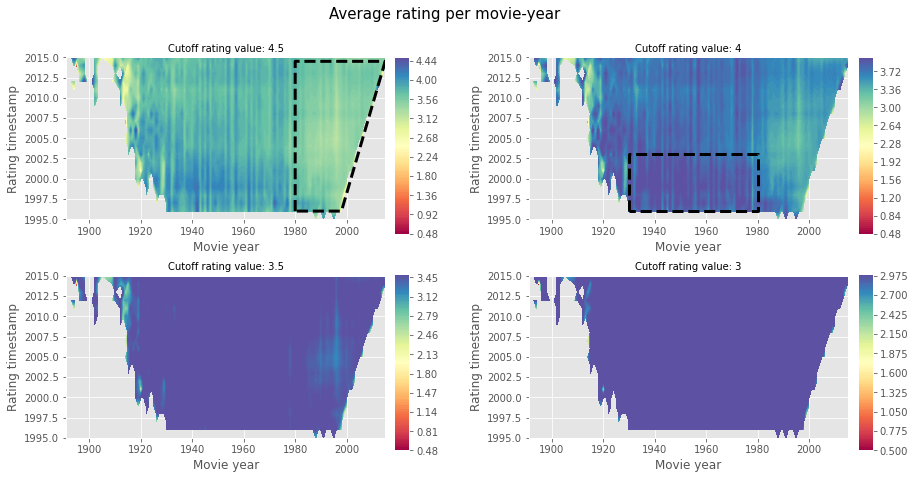

Elapsed time(sec):  4.19


In [ ]:
st = default_timer()
# Combine movies year with ratings timestamps
dftmp = movies[['movieId', 'year']].merge(ratings[['movieId', 'timestamp', 'rating']], on='movieId')
dftmp.drop('movieId', axis=1, inplace=True)
dftmp = dftmp.groupby(['year', 'timestamp']).mean().reset_index().pivot('year', 'timestamp')

# Plot using a contour (color reflects number of ratings for each year-timestamp pair).
# Could also use heatmap or imshow...
X=dftmp.columns.levels[1].values
Y=dftmp.index.values
Z=dftmp.values
Xi,Yi = np.meshgrid(X, Y)

fig, axs = plt.subplots(2,2)
fig.set_size_inches(14,7)
cutoff = [4.5, 4, 3.5, 3] # Modify the contour plots a different max values.
Zcap = np.copy(Z)
locx = [0.45, 0.91, 0.45, 0.91] # x location for the individual colorbars
locy = [0.53, 0.53, 0.1, 0.1] # y location for the individual colorbar
for i, ax in enumerate(axs.flatten()):
    Zcap[Zcap>cutoff[i]]=cutoff[i]
    cmvals = ax.contourf(Yi, Xi, Zcap, 100, cmap="Spectral")
    ax.set_xlabel('Movie year')
    ax.set_ylabel('Rating timestamp')
    ax.set_title('Cutoff rating value: %s' %cutoff[i], fontsize=10)
    cax = fig.add_axes([locx[i], locy[i], 0.015, 0.35])
    fig.colorbar(cmvals, cax=cax, orientation='vertical')
fig.suptitle('Average rating per movie-year', fontsize=15)
plt.subplots_adjust(hspace=0.35,wspace=0.45)

# Highlight key regions in the plots, just roughly...
axs.flatten()[0].plot([1980, 1980, 2015, 1998, 1980], [1996, 2014.5, 2014.5, 1996, 1996], 
                      '--', color='black', linewidth=3)
axs.flatten()[1].plot([1930, 1930, 1980, 1980, 1930], [1996, 2003, 2003, 1996, 1996], 
                      '--', color='black', linewidth=3)
plt.show()

#변수정리, 시간계산
%reset_selective -f (^ax$|^axs$|^cax$|^cmvals$|^cutoff$|^dftmp$|^fig$|^i$|loc|X|Y|Z)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

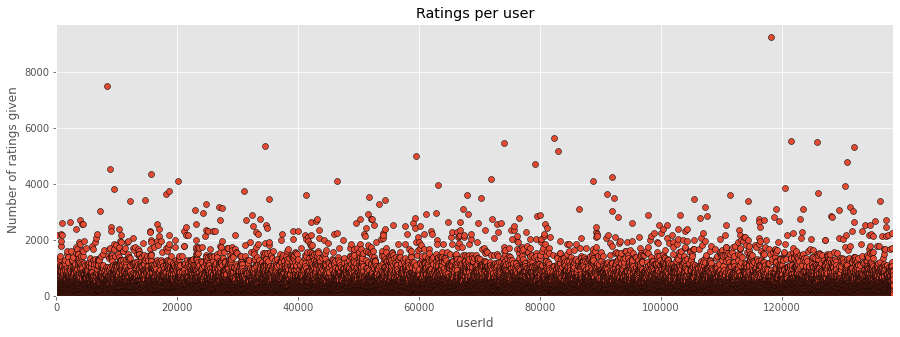

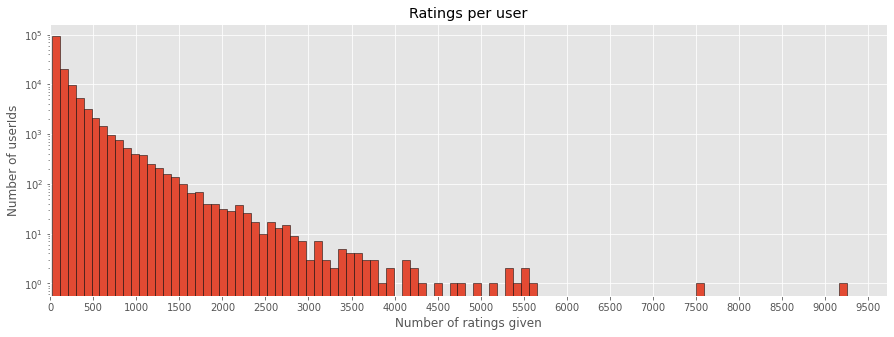

Elapsed time(sec):  1.93


In [ ]:
st = default_timer()

# rating의 user/movie 각각의 id를 가져오고user id로 묶은 다음, 숫자를 센다.
dftmp = ratings[['userId', 'movieId']].groupby('userId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')#scatter plot으로 찍는다.
plt.xlim(0,len(dftmp.index))#인덱스 길이만큼 x의 한계를 정해준다.
plt.ylim(0,)
plt.title('Ratings per user')
plt.xlabel('userId')
plt.ylabel('Number of ratings given')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)#100개로 쪼개진 histogram을 그린다.
plt.title('Ratings per user')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of userIds')
plt.xlim(0,)
plt.xticks(np.arange(0,10000,500))#0부터 1만까지 500단위로 띄는 x표시를 한다
plt.show()

#변수정리, 시간계산
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))


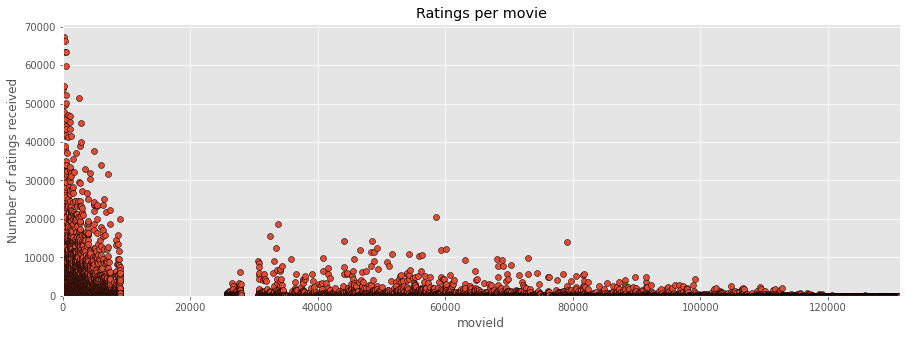

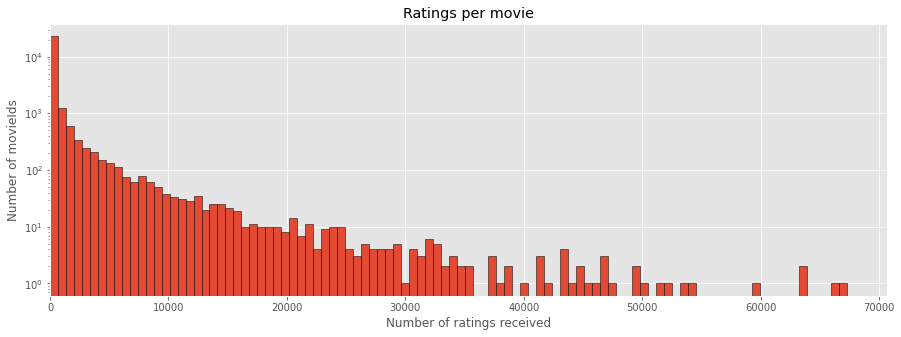

movieId
1                                               Toy Story
32                     Twelve Monkeys (a.k.a. 12 Monkeys)
47                                   Seven (a.k.a. Se7en)
50                                    Usual Suspects, The
110                                            Braveheart
150                                             Apollo 13
260                    Star Wars: Episode IV - A New Hope
296                                          Pulp Fiction
318                             Shawshank Redemption, The
356                                          Forrest Gump
377                                                 Speed
380                                             True Lies
457                                         Fugitive, The
480                                         Jurassic Park
527                                      Schindler's List
588                                               Aladdin
589                            Terminator 2: Judgment Day
590   

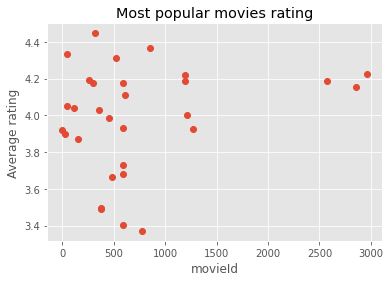

Best most popular movie ever is...Shawshank Redemption, The
Elapsed time(sec):  8.21


In [ ]:
st = default_timer()

# rating의 user/movie 의 id를 가져오고 movie id 기준으로 숫자를 센다
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')#scatter plot을 그린다
plt.xlim(0,dftmp.index.max())#최댓값을 한계점으로 한다
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)#100으로 나뉜 histogram을 그린다
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()

# movie를 id로 인덱스를 삼아주고, 이중 num_rating이 4만 이상인것의 title의 인덱스를 찾아 loc으로 위치를 뽑아준다.
print(movies.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]]['title'])
# rating을 id로 인덱스를 삼아주고 이중 num_rating이 4만 이상인 것의 위치를 찾은 후, id로 묶어줘서 평균을 내준다.그것을 plot으로 찍어준다.
ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]].groupby('movieId').mean().rating.plot(style='o')
plt.ylabel('Average rating')
plt.title('Most popular movies rating')
plt.show()

# rating의 id를 기준으로 인덱스를 삼아주고, 4만 이상인것을 찾은 후 id를 기준으로 묶어서 그 값의 평균을 내준다
tmp = ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]].groupby('movieId').mean()
# movie의 id를 기준으로 인덱스를 삼아주고, tmp의 rating(평균)이 가장 높은 애를 찾아 title을 찾아준다. 그것을 best에 담아 출력한다
best = movies.set_index('movieId').loc[tmp.rating.idxmax].title
print('Best most popular movie ever is...%s' %best)

#변수정리, 시간계산
%reset_selective -f (^dftmp$|^tmp$|^best$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

In [ ]:
runtime = default_timer() - start
print ("Elapsed time(sec): ", round(runtime,2))

#전체 변수정리, 시간계산
%reset_selective -f (^runtime$|^st$|^start$)

Elapsed time(sec):  125.72


In [ ]:
%whos

Variable        Type                          Data/Info
-------------------------------------------------------
default_timer   builtin_function_or_method    <built-in function perf_counter>
drive           module                        <module 'google.colab.dri<...>s/google/colab/drive.py'>
genres_unique   DataFrame                                      genre\n0<...>r\n19  (no genres listed)
movies          DataFrame                            movieId           <...>[27256 rows x 23 columns]
np              module                        <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
pd              module                        <module 'pandas' from '/u<...>ages/pandas/__init__.py'>
plt             module                        <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
ratings         DataFrame                               userId  movieId<...>0000263 rows x 4 columns]
